## 1. 下載MNIST資料集並觀察資料集基礎資訊

### Loading MNIST dataset

In [1]:
from tensorflow.keras.datasets import mnist

# 匯入Keras提供的mnist資料集(train: 60000, test: 10000, size=28x28, 共10類(0~9)手寫數字灰階圖像)
(train_Data, train_Label), (test_Data, test_Label) = mnist.load_data()

# 查看mnist資料集大小
print('train data=', len(train_Data))
print('test data=', len(test_Data))

#查看mnist資料集維度(channel, h, w)
print('train data dim=', train_Data.shape)
print('test label dim=', train_Label.shape)

train data= 60000
test data= 10000
train data dim= (60000, 28, 28)
test label dim= (60000,)


In [2]:
print(train_Data[0], "-" * 100, train_Data[1], sep='\n')

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

### 使用matplotlib輸出訓練資料集第一張images數字影像

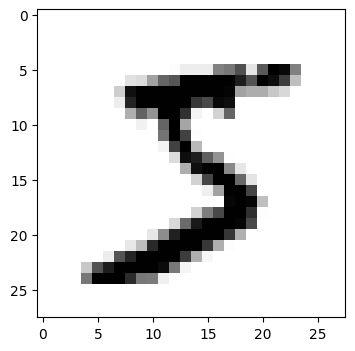

In [3]:
import matplotlib.pyplot as plt

def plot_image(data):  # 參數是要繪製的圖像或是陣列
    fig = plt.gcf()  # 獲取當前圖形對象
    fig.set_size_inches(4, 4)  # 設定圖像大小(單位：英吋)
    plt.imshow(data, cmap='binary')  # 設定顯示圖片以及顯示方式
    plt.show()  #顯示圖片
    
plot_image(train_Data[0])

### 輸出訓練集第一筆資料的標籤值驗證資料集與標籤是否相互對應

In [4]:
print('train_Label[0]: ', train_Label[0])

train_Label[0]:  5


## 2. 設置超參數與訓練資料前處理

### 設定訓練網路需要的超參數跟資料大小轉換

In [5]:
import tensorflow as tf

# 訓練參數設定
learning_rate = 0.01  # 學習率
training_epoch = 1000  # 訓練次數
batch_size = 2000  # 每次訓練大小


# MNIST 資料的前置處理
"""
將原本是 28x28 的影像攤平成 784, 拿來當輸入特徵;
reshape([-1, 784]), -1這個參數設定表示不在乎原本矩陣維度讓tf自動將新矩陣拉成, 最適列數x784行數 的矩陣(28x28 => 1x784))
"""
train_Data_R, test_Data_R = train_Data.reshape([-1, 784]).astype('float32'), test_Data.reshape([-1, 784]).astype('float32')

# 資料正規化(防止資料內部數值散布範圍過大並加速神經網路計算處理)
train_Data_R, test_Data_R = train_Data_R / 255., test_Data_R / 255.

# 將資料分批並且打散
"""
用from_tensor_slices函數，自陣列建立 Dataset

tensorflow Dataset api: 以下筆記 shuffle, batch 和 repeat, 此三項順序會影響資料集的洗牌程度
Shuffle -> Repeat -> Batch，是比較好的洗牌方式

．shuffle(buffer_size): 將前buffer_size(這裡設5000)筆資料做shuffle, 通常全部拿來做shuffle得到的結果會最隨機, 但要考慮訓練機器的記憶體大小
．batch(batch_size): 就是將原本分散一筆一筆的資料以批次的方式包起來, 每個訓練的step就會拿到同樣 batch size 的樣本來訓練
　若資料集總筆數無法被batch_size整除, 則某一次拿取資料會拿到餘數筆資料做訓練, ex: total 13, batch size 4 => 拿到3次4筆 + 1次1筆
．repeat(count): 其功能為要重覆這個 dataset 的元素幾次, 如果是count=2，那你可以做到在一個 epoch 內對每筆資料掃過兩次的效果, 
　當count=None時, 即代表無限重覆, 此時要注意你在 model.fit() 時，必須指定 steps_per_epoch，不然會永遠算不完一個 epoch 而錯誤！
"""
train_Data_M = tf.data.Dataset.from_tensor_slices((train_Data_R, train_Label))
train_Data_M = train_Data_M.shuffle(5000).batch(batch_size)

## 3. 設計網路

In [6]:
# 最後的 Dense(10)且activation 用softmax, 代表最後的output 為 10 個 class(0~9)的機率
# softmax 主要用於多分類過程, 將多個神經元輸出, 映射到(0~1)區間內(可看成機率來理解)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

## 4. 選擇優化器、損失函數
1. 用優化器找出參數(weights)的梯度(利用偏微分方法, 損失函數對參數的梯度), 往梯度的方向更新參數, 優化模型參數\
    W <- W - (learning rate) x 偏微分(Loss/W)，其中 W 為權重(weight)參數、Loss 為損失函數(Loss function)
2. 網路模型最後的參數修正好壞有絕大部分因素來自損失函數設計

In [7]:
# 隨機梯度下降優化器
optimizer = tf.keras.optimizers.SGD(learning_rate)

# 此模型要處理分類問題, 分類問題常用的損失函數為交叉熵
def cross_entropy_loss(x, y):
    # 將標籤轉換為 int64
    y = tf.cast(y, tf.int64)
    # 選擇交叉熵當損失函數
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # 計算平均損失
    return tf.reduce_mean(loss)

## 5. 定義正確率
程式在每個階段不斷計算損失並用優化器修正模型參數後, 會使用測試集中測試資料來測試模型的強健性, 因此需定義正確率函數判斷測試後的正確程度


In [10]:
# 計算準確率
def accuracy(y_pred, y_true):
    # tf.argmax(y_pred, 1) 返回 y_pred 維度為1的最大索引跟正確值做比較
    correct_prediction = tf.equal(tf.argmax(y_pred, 1),
                                 tf.cast(y_true, tf.int64))
    # 計算平均正確率
    return tf.reduce_mean(tf.cast(correct_prediction, 
                                 tf.float32), axis=-1)

## 6. 定義訓練與測試方法
當模型經輸入資料做前向運算後, 會得到各類的機率值\
再將機率最高的索引值與樣本的標籤比較是否相等, 如果相等代表判斷正確, 不相等代表判斷錯誤
1. 將訓練資料分批輸入模型做前向訓練, 再計算損失值並進行模型參數修正, 當所有訓練資料權輸入結束並完成前向運算, 稱為1個epoch
2. 每完成1個epoch, 程式會把測試資料帶入計算並計算損失與正確率, 並將每1個epoch的損失值與正確率加以記錄

In [11]:
testlossArr = []  # 記錄每一個 epoch 的損失值
testaccArr = []  # 記錄每一個 epoch 的正確率
epochs = []  # 記錄每一個 epoch 值
Testloss = 0  # 記錄測試集當下 epoch 的損失率
Testacc = 0  # 記錄測試集當下 epoch 的正確率
epoch = 0

for epoch in range(training_epoch):
    for step, (batch_data, batch_label) in enumerate(train_Data_M):
        with tf.GradientTape() as tape:
            pre_data = model(batch_data)
            # Compute loss
            loss = cross_entropy_loss(pre_data, batch_label)
            acc = accuracy(pre_data, batch_label)
            trainable_variables = model.trainable_variables
            # 計算梯度
            gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    # 每訓練完一個Epoch, 就拿測試集來測試準確率
    Testprec = model(test_Data_R)
    Testloss = cross_entropy_loss(Testprec, test_Label)
    Testacc = accuracy(Testprec, test_Label)
    
    print("Testloss: %f, Testaccuracy: %f" % (Testloss, Testacc))
    print(epoch)
    testlossArr.append(Testloss)
    testaccArr.append(Testacc)
    epochs.append(epoch)
    

Testloss: 2.299196, Testaccuracy: 0.130000
0
Testloss: 2.297883, Testaccuracy: 0.133300
1
Testloss: 2.296505, Testaccuracy: 0.138600
2
Testloss: 2.295060, Testaccuracy: 0.142700
3
Testloss: 2.293532, Testaccuracy: 0.145500
4
Testloss: 2.291915, Testaccuracy: 0.147600
5
Testloss: 2.290194, Testaccuracy: 0.152200
6
Testloss: 2.288352, Testaccuracy: 0.157500
7
Testloss: 2.286379, Testaccuracy: 0.161900
8
Testloss: 2.284254, Testaccuracy: 0.166700
9
Testloss: 2.281959, Testaccuracy: 0.173800
10
Testloss: 2.279471, Testaccuracy: 0.178400
11
Testloss: 2.276765, Testaccuracy: 0.182300
12
Testloss: 2.273803, Testaccuracy: 0.188600
13
Testloss: 2.270552, Testaccuracy: 0.195300
14
Testloss: 2.266966, Testaccuracy: 0.202900
15
Testloss: 2.262990, Testaccuracy: 0.212400
16
Testloss: 2.258564, Testaccuracy: 0.221500
17
Testloss: 2.253618, Testaccuracy: 0.232000
18
Testloss: 2.248077, Testaccuracy: 0.245100
19
Testloss: 2.241882, Testaccuracy: 0.258400
20
Testloss: 2.235016, Testaccuracy: 0.271900
2

Testloss: 1.585234, Testaccuracy: 0.898200
177
Testloss: 1.584639, Testaccuracy: 0.898800
178
Testloss: 1.584097, Testaccuracy: 0.898900
179
Testloss: 1.583515, Testaccuracy: 0.898900
180
Testloss: 1.582981, Testaccuracy: 0.899900
181
Testloss: 1.582447, Testaccuracy: 0.900000
182
Testloss: 1.581941, Testaccuracy: 0.900500
183
Testloss: 1.581423, Testaccuracy: 0.900600
184
Testloss: 1.580923, Testaccuracy: 0.900500
185
Testloss: 1.580422, Testaccuracy: 0.901400
186
Testloss: 1.579939, Testaccuracy: 0.901700
187
Testloss: 1.579466, Testaccuracy: 0.901900
188
Testloss: 1.579009, Testaccuracy: 0.902400
189
Testloss: 1.578549, Testaccuracy: 0.902800
190
Testloss: 1.578115, Testaccuracy: 0.902900
191
Testloss: 1.577673, Testaccuracy: 0.903500
192
Testloss: 1.577235, Testaccuracy: 0.903600
193
Testloss: 1.576822, Testaccuracy: 0.903700
194
Testloss: 1.576417, Testaccuracy: 0.903800
195
Testloss: 1.575988, Testaccuracy: 0.904200
196
Testloss: 1.575582, Testaccuracy: 0.904600
197
Testloss: 1.5

Testloss: 1.546520, Testaccuracy: 0.924200
352
Testloss: 1.546420, Testaccuracy: 0.924500
353
Testloss: 1.546324, Testaccuracy: 0.924700
354
Testloss: 1.546222, Testaccuracy: 0.924600
355
Testloss: 1.546123, Testaccuracy: 0.925000
356
Testloss: 1.546017, Testaccuracy: 0.925100
357
Testloss: 1.545921, Testaccuracy: 0.925100
358
Testloss: 1.545818, Testaccuracy: 0.925100
359
Testloss: 1.545729, Testaccuracy: 0.925600
360
Testloss: 1.545623, Testaccuracy: 0.925600
361
Testloss: 1.545534, Testaccuracy: 0.925500
362
Testloss: 1.545439, Testaccuracy: 0.925400
363
Testloss: 1.545347, Testaccuracy: 0.925500
364
Testloss: 1.545240, Testaccuracy: 0.925700
365
Testloss: 1.545145, Testaccuracy: 0.926100
366
Testloss: 1.545066, Testaccuracy: 0.925800
367
Testloss: 1.544964, Testaccuracy: 0.926100
368
Testloss: 1.544861, Testaccuracy: 0.926200
369
Testloss: 1.544768, Testaccuracy: 0.926200
370
Testloss: 1.544688, Testaccuracy: 0.926100
371
Testloss: 1.544585, Testaccuracy: 0.926500
372
Testloss: 1.5

Testloss: 1.533930, Testaccuracy: 0.934600
527
Testloss: 1.533884, Testaccuracy: 0.934700
528
Testloss: 1.533844, Testaccuracy: 0.934700
529
Testloss: 1.533788, Testaccuracy: 0.934800
530
Testloss: 1.533729, Testaccuracy: 0.934700
531
Testloss: 1.533682, Testaccuracy: 0.934800
532
Testloss: 1.533632, Testaccuracy: 0.935000
533
Testloss: 1.533581, Testaccuracy: 0.934900
534
Testloss: 1.533526, Testaccuracy: 0.935000
535
Testloss: 1.533478, Testaccuracy: 0.934900
536
Testloss: 1.533421, Testaccuracy: 0.934900
537
Testloss: 1.533374, Testaccuracy: 0.935100
538
Testloss: 1.533324, Testaccuracy: 0.935100
539
Testloss: 1.533276, Testaccuracy: 0.935100
540
Testloss: 1.533225, Testaccuracy: 0.935000
541
Testloss: 1.533174, Testaccuracy: 0.935000
542
Testloss: 1.533121, Testaccuracy: 0.935100
543
Testloss: 1.533073, Testaccuracy: 0.935000
544
Testloss: 1.533033, Testaccuracy: 0.935200
545
Testloss: 1.532969, Testaccuracy: 0.935000
546
Testloss: 1.532926, Testaccuracy: 0.935200
547
Testloss: 1.5

Testloss: 1.526498, Testaccuracy: 0.939900
702
Testloss: 1.526468, Testaccuracy: 0.940000
703
Testloss: 1.526434, Testaccuracy: 0.940200
704
Testloss: 1.526391, Testaccuracy: 0.940100
705
Testloss: 1.526362, Testaccuracy: 0.939900
706
Testloss: 1.526323, Testaccuracy: 0.940200
707
Testloss: 1.526278, Testaccuracy: 0.940300
708
Testloss: 1.526254, Testaccuracy: 0.940300
709
Testloss: 1.526221, Testaccuracy: 0.940300
710
Testloss: 1.526178, Testaccuracy: 0.940300
711
Testloss: 1.526147, Testaccuracy: 0.940300
712
Testloss: 1.526124, Testaccuracy: 0.940300
713
Testloss: 1.526085, Testaccuracy: 0.940400
714
Testloss: 1.526053, Testaccuracy: 0.940400
715
Testloss: 1.526015, Testaccuracy: 0.940400
716
Testloss: 1.525990, Testaccuracy: 0.940300
717
Testloss: 1.525946, Testaccuracy: 0.940500
718
Testloss: 1.525914, Testaccuracy: 0.940600
719
Testloss: 1.525878, Testaccuracy: 0.940700
720
Testloss: 1.525844, Testaccuracy: 0.940700
721
Testloss: 1.525806, Testaccuracy: 0.940900
722
Testloss: 1.5

Testloss: 1.521043, Testaccuracy: 0.945800
877
Testloss: 1.521013, Testaccuracy: 0.945800
878
Testloss: 1.520992, Testaccuracy: 0.945900
879
Testloss: 1.520962, Testaccuracy: 0.945800
880
Testloss: 1.520935, Testaccuracy: 0.945800
881
Testloss: 1.520910, Testaccuracy: 0.945900
882
Testloss: 1.520879, Testaccuracy: 0.945900
883
Testloss: 1.520848, Testaccuracy: 0.945800
884
Testloss: 1.520825, Testaccuracy: 0.945900
885
Testloss: 1.520800, Testaccuracy: 0.945800
886
Testloss: 1.520768, Testaccuracy: 0.945900
887
Testloss: 1.520737, Testaccuracy: 0.945900
888
Testloss: 1.520710, Testaccuracy: 0.945800
889
Testloss: 1.520684, Testaccuracy: 0.946000
890
Testloss: 1.520653, Testaccuracy: 0.945900
891
Testloss: 1.520626, Testaccuracy: 0.945800
892
Testloss: 1.520595, Testaccuracy: 0.945900
893
Testloss: 1.520567, Testaccuracy: 0.946000
894
Testloss: 1.520541, Testaccuracy: 0.946100
895
Testloss: 1.520509, Testaccuracy: 0.945900
896
Testloss: 1.520483, Testaccuracy: 0.946000
897
Testloss: 1.5

## 7. 印出最後與完整的訓練之損失值與正確率

<function matplotlib.pyplot.show(close=None, block=None)>

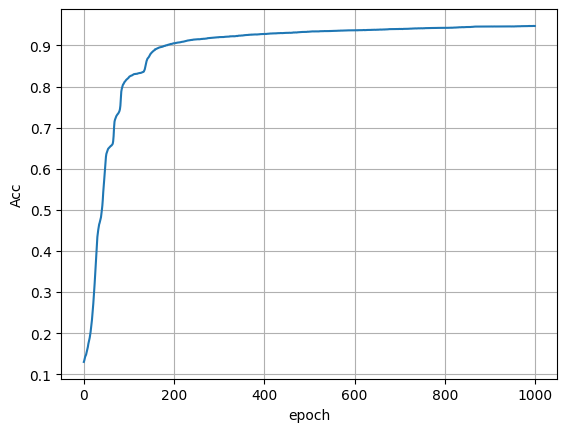

In [12]:
plt.plot(epochs, testaccArr)
plt.xlabel("epoch")
plt.ylabel("Acc")
plt.grid()
plt.show